In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import nltk, string, random, numpy, os
import matplotlib.pyplot as plt
from typing import List
os.makedirs('./results', exist_ok=True)
nltk.download('brown')
random.seed(42)
torch.manual_seed(42)
numpy.random.seed(42)
print("Done")

Done


[nltk_data] Downloading package brown to
[nltk_data]     /Users/kierankeesmaat/nltk_data...
[nltk_data]   Package brown is already up-to-date!


### Introduction
In the warm-up of this assignment, we will see how Neural Networks (NN) handle natural language data.   
The warm-up focuses on a simple Multilayer Perceptron (MLP), also known as a fully connected Neural Network. The data we'll use is the first 5000 unique words of the Brown corpus.

### Dataset
To train the model, we will have to represent the input words to the model in some way. Since models solely work with numbers, the words will have to be converted into numerical form.  
For this assignment, we will focus on predicting individual words from the dataset given the input of the model. The input will be the target word split up into individual letters. To represent these individual letters we will give the model a vector of 26 positions (26 letters in the English alphabet). Initially, this vector is filled with zeros and for every occuring letter in the word we change the value to 1 in that position. For instance, in the word `apple', we have 1 a, 1 e, 1 l and 2 p. The vector will then represent the word as:  
```[1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0]```  
You will have to implement this algorithm together with loading the Brown dataset and taking the first 5000 unique words. Implement a way to store the indexes of the unique words as a dictionary where the word is the key and the index is the value as well as the target list (which will be just the indexes of the words).

In [2]:
#  import brown corpus       
from nltk.corpus import brown

class AlphaDataset(Dataset):
    def __init__(self) -> None:
        # Load the NLTK Brown corpus and store the first 5000 unique words of the corpus in self.data
        self.data = []
        
        # get the brown corpus words and create a seen words set to keep track of already seen words
        brown_words = [word.lower() for word in brown.words()]
        seen_words = set()
        
        # loop through the brown words until 5000 unique words have been found
        for word in brown_words:
            if word.isalpha() and word not in seen_words:
                seen_words.add(word)
                self.data.append(word)
            if len(self.data) == 5000:
                break
        
        # Convert the unique words to an index dictionary {word: index}
        self.word_to_idx = {}
        for idx, word in enumerate(self.data):
            self.word_to_idx[word] = idx
            
        # Make these indexes the target values
        self.targets = []
        for word in self.data:
            self.targets.append(self.word_to_idx[word])

    def __len__(self) -> int:
        # Torch requires the implementation of the length function to calculate the number of instances in the dataset. Find a way to implement this
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        # Apply processing to turn the word (stored in x) into a numeric vector of 26 numbers, counting the occurences of the letters.
        # Example: apple would become [1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0], counting 2 occurences for the letter p and zero for letters that do not occur.
        
        # create blank vector
        vector = [0] * 26
        
        # loop through letters in word (x)
        for char in x:
            
            # make sure character is lowercase letter get index and add to vector
            if char in string.ascii_lowercase:
                index = ord(char) - ord('a')
                vector[index] += 1
                
        x = vector
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        return x, y
    

### Multilayer Perceptron
In the following section, you will implement a MLP. The goal is to implement this MLP with 1 input layer, 2 hidden layers, and 1 output layer.
With PyTorch, the linear layer is most suitable for this. When you create a linear layer, you define the input and output size of the layer, effectively creating two linear neuron layers. This is useful to know since we only need to create 3 linear layer classes to have the 4 layers we want.
The hidden size is stored as a list where the first value will be 256 and the second value will be 512.

In [3]:
class MLP(nn.Module):
    def __init__(self, input_size: int, hidden_size: List[int], output_size: int) -> None:
        super().__init__()
        # Implement the neural network layers, the activation function is already defined
        self.input_layer = nn.Linear(input_size, hidden_size[0])
        self.hidden_layer = nn.Linear(hidden_size[0], hidden_size[1])
        self.output_layer = nn.Linear(hidden_size[1], output_size)

        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # In the forward pass the model will calculate the gradients as well as the probabilities of the result occuring given its input.
        # Implement the missing layers

        x = self.input_layer(x) # Implement input layer
        x = self.activation(x)
        x = self.hidden_layer(x) # Implement hidden layer
        x = self.activation(x)
        x = self.output_layer(x) # Implement the output layer

        return x

### Setting up the hyperparameters
These are the hyperparameters used for the model, they define the layout of the model as well as the performance:
- batch_size, defines the number of instances the model sees at one time.
- learning_rate, defines the change rate of the gradient descent.
- input_size, the number of input neurons for the model, the number of letters in the alphabet
- hidden_size, the number of neurons in the hidden layer
- output_size, the number of neurons in the output layer, for us this is the number of unqiue words

In [4]:
batch_size = 8
learning_rate = 1e-5
input_size = 26
hidden_size = [256, 512]
output_size = 5000
device = 'mps' # If you have an m1 macbook use: 'mbs', if you have an NVIDIA GPU use: 'cuda:0' else leave as is

Setting up the dataset

In [5]:
# Define the dataset and the dataloader
dataset = AlphaDataset()

# For the final evaluation of the model we will use 20% of the data for testing. Testing is only ever done after hyperparameter tuning.
# Split sizes (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# To evaluate our model we want to take 10% of the dataset for validation, this is similar to the testset, rather this data we can use during hyperparameter tuning.
# The validation and test data is never trained on and is unseen data for the model, making it closer to a production setting.
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffling ensures the model does not overfit on ordering of the data.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # This data does not need to be shuffled
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  #T his data does not need to be shuffled

### Preperation for training
Here we load the model into memory, apply it to the selected device and define the optimizer. The optimizer guides the model to the best possible state it can be in through Gradient descent.
Lastly, the loss function is defined, this defines how well the model performs, based on this number the model knows how it should change its weights.

In [6]:
model = MLP(input_size, hidden_size, output_size)
model.to(device) # Tell de model which accelerator to use (Macbook GPU, NVIDIA GPU or CPU)

# In Neural Networks optimizers handle the efficient training through gradient descent, we will use Adam
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# The loss function defines how well the model is performing, if the loss is low the model is rewarded, if it is high the model is punished.
# Since we are dealing with a classification task we will use Cross Entropy
loss_fn = nn.CrossEntropyLoss()

### Training
In the next block the training block is already defined. This is a standard way to train the model for 50 epochs (50 times it will see the dataset). Each time it does one epoch we also go over the validationset.

In [7]:
training_losses = []
validation_losses = []

for epoch in range(50): # Train for 50 epochs
    model.train() # Enforce model training
    for step, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        training_losses.append(loss.item())
        print(loss.item(), end='\r')

        loss.backward() # Calculate gradients

        optimizer.step() # Reward the model
        optimizer.zero_grad() # Clean the gradients
    print('Training_loss:', loss.item())

    model.eval() # After every training epoch we want to see the model's performance on the validation data
    with torch.no_grad(): # In validation we dont need gradients so we tell torch to not calculate them
        total_val_loss = 0
        for step, (x, y) in enumerate(val_loader):
            x = x.to(device)
            y = y.to(device)

            output = model(x)

            loss = loss_fn(output, y)

            total_val_loss += loss.item()

        validation_losses.append(total_val_loss / len(val_dataset))
        print('Validation_loss:', validation_losses[-1])

Training_loss: 8.533097267150879
Validation_loss: 1.0698297429084778
Training_loss: 8.46747875213623
Validation_loss: 1.0805800461769104
Training_loss: 8.311607360839844
Validation_loss: 1.0982918190956115
Training_loss: 8.251202583312988
Validation_loss: 1.128314425945282
Training_loss: 7.983465671539307
Validation_loss: 1.1727497506141662
Training_loss: 7.970180511474609
Validation_loss: 1.227898862361908
Training_loss: 7.916754245758057
Validation_loss: 1.2880531644821167
Training_loss: 7.763303756713867
Validation_loss: 1.349501233100891
Training_loss: 7.631609916687012
Validation_loss: 1.4107510113716126
Training_loss: 7.309067726135254
Validation_loss: 1.472150411605835
Training_loss: 7.424538612365723
Validation_loss: 1.5343356680870057
Training_loss: 7.485544204711914
Validation_loss: 1.5976407098770142
Training_loss: 7.196179389953613
Validation_loss: 1.6628162360191345
Training_loss: 7.192887306213379
Validation_loss: 1.7299873805046082
Training_loss: 7.00924015045166
Validat

### Writing
Below we can print the training statistics, the training loss should be going down while the validation loss should be going up. What does it mean that the validation loss increases?

This means that our model is overfitting to the specifics of the training data and is not generalising well to the unseen validation data.

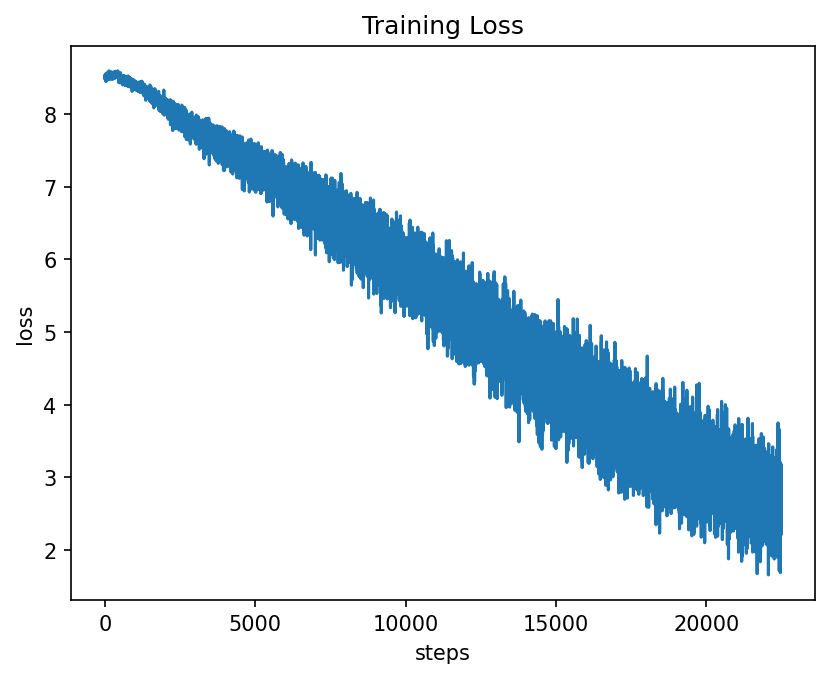

In [8]:
plt.rcParams['figure.dpi'] = 150
plt.plot(training_losses)
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Training Loss')
plt.savefig('./results/training_loss.png')

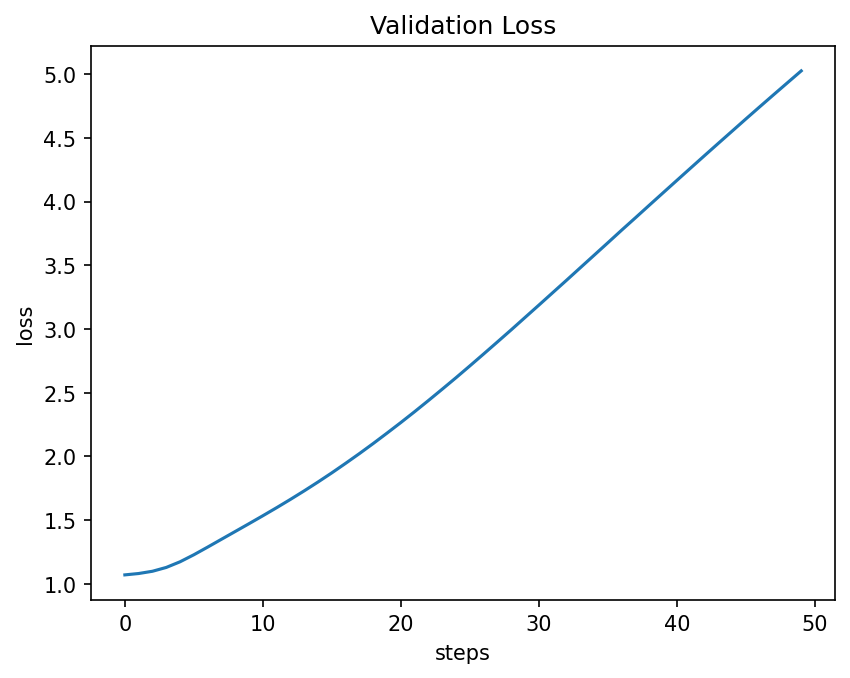

In [9]:
plt.plot(validation_losses)
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Validation Loss')
plt.savefig('./results/validation_loss.png')

### Writing
Below we want to analyze how the model functions based on the test data. What stands out from these results? Was the result correct? What is the main difference between the words?

The model results were not very accurate. As can be seen, only two of the predictions are somewhat semantically related to the target (e.g dividing predicted for division and succeed predicted for succeeds). The rest do not appear to show any semantic similarity (e.g precinct predicted for accepting and plays predicted for polls), however, there is a lot of character overlap. For example, the model predicted motions for composition and it can be seen that each character in motions appears at least once in composition.

In [14]:
def get_n_words(dataset, n, model, ds, verbose=True):
    if n == -1:
        n = len(dataset)
        
    device = next(model.parameters()).device  # Automatically detect model device
    
    x = [dataset.__getitem__(i)[0].to(device) for i in range(n)]
    y = [dataset.__getitem__(i)[1] for i in range(n)]
    
    idx_to_word = {idx: word for word, idx in ds.word_to_idx.items()}
    target_words = [idx_to_word[_.item()] for _ in y]
    
    model.eval()
    with torch.no_grad():
        out = [nn.functional.softmax(model(wrd), dim=0).argmax() for wrd in x]
    
    predicted_words = [idx_to_word[_.item()] for _ in out]
    width = max(len(word) for word in target_words) + 5
    
    if verbose:
        print('\n'.join([f'target: {t.ljust(width)} predicted: {p}' for t, p in zip(target_words, predicted_words)]))
    
    return target_words, predicted_words

_,_ = get_n_words(test_dataset, 10, model, dataset)

target: composition      predicted: motions
target: division         predicted: dividing
target: widely           predicted: middle
target: accepting        predicted: precinct
target: indemnity        predicted: imminent
target: polls            predicted: plays
target: succeeds         predicted: succeed
target: pardoned         predicted: dropped
target: honest           predicted: northwestern
target: poll             predicted: payroll


Why are some words incorrectly predicted?

The model only uses letter counts to try and predict the correct word, without taking into account the ordering of these characters. This is a coarse-grained method that does not distinguish between a perfect match and potential anagrams. For example, the model would predict both listen and silent with equal probability for the target word listen. This is because they contain the exact same characters, and this is what this model looks for.

### Code + Written
Research the Jaccard similarity metric for calculating the difference between the predicted word and the target word. Reference your sources and implement this metric in your code below. You can use the get_n_words function with n=-1 to get all the predicted and target words. Compare this method to similarity as measured with one of the word vector methods from A2, in writing and/or code.

We obtained the Jaccard Similarity definition and example from: [LearnDataSci Glossary – Jaccard Similarity](https://www.learndatasci.com/glossary/jaccard-similarity/). The similarity measure from A2 that we chose was the cosine similarity score, measured between two GloVe word embeddings as from the [Stanford NLP paper on GloVe](https://nlp.stanford.edu/pubs/glove.pdf).

The average Jaccard similarity score ended up being 0.7396, whereas the GloVe cosine similarity score averaged 0.2068. This makes sense as our model predictions were based on character-level similarity and were not able to capture semantic similarity between most word pairs. The Jaccard similarity rewards this as it is a superficial measure of unique character overlap, and does not take into account any shared meaning beyond that.

The GloVe word embeddings on the other hand have been developed in such a way as to capture semantic similarities between words based on distributional patterns in large corpora. As our model was not able to capture these relationships, the cosine similarity scores reflect this, with the low scores demonstrating that the predicted words are not very semantically related to the target words.



In [ ]:
# Jaccard similarity
# create function to calculate Jaccard similarity between two strings
def jaccard_similarity(a: str, b: str) -> float:
    ''' this function takes in two strings and returns the Jaccard similarity between them.'''

    # convert strings to sets, get intersection and union
    set_a = set(a)
    set_b = set(b)
    intersection = set_a.intersection(set_b)
    union = set_a.union(set_b)

    # check to make sure union is not empty
    if not union:
        return 0.0  
    
    # calculate and return final Jaccard similarity
    return len(intersection) / len(union)

# create function to calculate Jaccard similarity between target and predicted words
def evaluate_jaccard(dataset, model, ds):
    ''' this function takes in a dataset and a model and returns the average 
        Jaccard similarity between the target and predicted words from the dataset.'''
    
    # Get all target and predicted words
    target_words, predicted_words = get_n_words(dataset, n=-1, model=model, ds=ds, verbose=False)

    jaccard_scores = []

    # get target, prediction pairs, their Jaccard similarity and append to list
    for target, predicted in zip(target_words, predicted_words):
        score = jaccard_similarity(target, predicted)
        jaccard_scores.append(score)

    # get average Jaccard score and print + return
    avg_jaccard = sum(jaccard_scores) / len(jaccard_scores)
    print(f"Average Jaccard similarity: {avg_jaccard:.4f}")
    return avg_jaccard


evaluate_jaccard(test_dataset, model, dataset)


Average Jaccard similarity: 0.7396


0.7396028499278497

In [ ]:
# Method 2 GloVe word embeddings
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity

# get GloVe word embeddings
wv = api.load("glove-wiki-gigaword-200")

# create function to calculate cosine similarity between two words from GloVe embeddings
def glove_cosine_similarity(word1, word2, glove_model):
    '''returns cosine similarity between two words using GloVe embeddings'''
    if word1 in glove_model and word2 in glove_model:
        v1 = glove_model[word1].reshape(1, -1)
        v2 = glove_model[word2].reshape(1, -1)
        return cosine_similarity(v1, v2)[0][0]
    else:
        return None  # Out-of-vocabulary
    

# get cosine similarity between the target and predicted words
def evaluate_glove_cosine(dataset, model, ds, glove_model):
    '''gets cosine similarity of predictions and targets using GloVe embeddings
       and returns the average + number of missing words '''
    
    # get all target and predicted words
    target_words, predicted_words = get_n_words(dataset, n=-1, model=model, ds=ds, verbose=False)
    
    cosine_scores = []
    skipped = 0
    
    # get target, prediction pairs, their cosine similarity and append to list
    for target, predicted in zip(target_words, predicted_words):
        score = glove_cosine_similarity(target, predicted, glove_model)
        if score is not None:
            cosine_scores.append(score)
        else:
            skipped += 1

    avg_score = sum(cosine_scores) / len(cosine_scores)
    print(f"Average Cosine Similarity (GloVe): {avg_score:.4f}")
    print(f"Skipped {skipped} word pairs (one or both words not in GloVe vocab)")
    return avg_score

evaluate_glove_cosine(test_dataset, model, dataset, wv)


Average Cosine Similarity (GloVe): 0.2068
Skipped 19 word pairs (not in GloVe vocab)


0.2067608164302555